# Neuron Synapse Competition

## Importing Libraries

In [ ]:
!pip install minisom

In [ ]:
import time

time_start = time.perf_counter()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import drive

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

from minisom import MiniSom

from sklearn.cluster import DBSCAN, KMeans
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import RFE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC

from tqdm import tqdm

from xgboost import XGBClassifier

## Initializing Functions

In [ ]:
dbscan = DBSCAN()

In [ ]:
lof = LocalOutlierFactor()

In [ ]:
brf = BalancedRandomForestClassifier(random_state=42)

In [ ]:
# Setting contamination to approximate imbalance ratio
isolation_forest = IsolationForest(contamination=0.01, random_state=42)

In [ ]:
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

In [ ]:
def engineer_features(df, encoder_type='Label'):
    if encoder_type == 'Label':
      label_encoder = LabelEncoder()
    elif encoder_type == 'OneHot':
      label_encoder = OneHotEncoder()

    features_to_encode = [
        'compartment',
        'pre_brain_area',
        'post_brain_area',
        'projection_group'
    ]

    df[features_to_encode] = df[features_to_encode].apply(label_encoder.fit_transform)

    df['weighted_similarity'] = df['fw_similarity'] * 0.7 + df['adp_dist'] * 0.3

    df['euclidean_dist'] = np.sqrt((df['axonal_coor_x'] - df['dendritic_coor_x'])**2 +
                                   (df['axonal_coor_y'] - df['dendritic_coor_y'])**2 +
                                   (df['axonal_coor_z'] - df['dendritic_coor_z'])**2)

    df['adp_times_euclidean'] = df['adp_dist'] * df['euclidean_dist']

    df['fw_similarity_squared'] = df['fw_similarity'] ** 2

    missing_features = [col for col in df.columns if df[col].isnull().any()]

    df = df.drop(columns=missing_features).select_dtypes(exclude=['object'])

    return df

In [ ]:
def svm_classifier(train_data, train_labels, test_data, scaling='MinMaxScaler'):
    svm_clf = SVC(kernel='rbf', class_weight='balanced', C=1.0, random_state=42)

    if scaling != None:
        print("Scaling Data...")
        if scaling == 'MinMaxScaler':
            scaler = MinMaxScaler()
        elif scaling == 'StandardScaler':
            scaler = StandardScaler()
        train_data = scaler.fit_transform(train_data)
        test_data = scaler.transform(test_data)

    svm_clf.fit(train_data, train_labels)

    return svm_clf.predict(test_data)

In [ ]:
def xgboost_pipeline(
    train_data,
    train_labels,
    test_data,
    scaling=None,
    rfe=True,
    ros=True
):
    print("Initializing XGBoost Classifier...")
    xgb_clf = XGBClassifier(
        objective="binary:logistic",
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=99
    )

    if ros == True:
      print("Applying Random Over Sampler...")
      ros = RandomOverSampler(random_state=0)
      train_data, train_labels = ros.fit_resample(train_data, train_labels)

    if rfe == True:
      print("Selecting Features...")
      selector = RFE(estimator=xgb_clf, step=1)
      train_data = selector.fit_transform(train_data, train_labels)
      test_data = selector.transform(test_data)
      print(train_data.shape)

    if scaling != None:
        print("Scaling Data...")
        if scaling == 'MinMaxScaler':
            scaler = MinMaxScaler()
        elif scaling == 'StandardScaler':
            scaler = StandardScaler()
        train_data = scaler.fit_transform(train_data)
        test_data = scaler.transform(test_data)


    if cv == True:
        print("Grid Search w/ Stratified K-Fold f/ Best Fit Model...")

        param_grid = {
            'max_depth': [3, 4, 5],
            'n_estimators': [50, 100, 200],
            'scale_pos_weight': [1, 5, 10],
            'reg_lambda': [0.01, 0.1, 1.0],
            'learning_rate': [0.01, 0.05, 0.1]
        }

        cv = StratifiedKFold(n_splits=3)

        grid_search = GridSearchCV(
            estimator=xgb_clf,
            param_grid=param_grid,
            cv=cv,
            n_jobs=-1,
            scoring='balanced_accuracy',
            verbose=1
        )

        grid_search.fit(train_data, train_labels)

        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print("Predicting from Grid Searched Best Fit Model...")
        return grid_search.predict(test_data)

    xgb_clf.fit(train_data)

    return xgb_clf.predict(test_data)

## Load &amp; Preprocess Data

### Read Datasets

In [ ]:
# from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load in training and testing data on each potential synapse
data = pd.read_csv("./drive/MyDrive/neuron-synapse-prediction/train_data.csv")
lb_data = pd.read_csv("./drive/MyDrive/neuron-synapse-prediction/leaderboard_data.csv")

# load in additional features for each neuron
feature_weights = pd.read_csv("./drive/MyDrive/neuron-synapse-prediction/feature_weights.csv")
morph_embeddings = pd.read_csv("./drive/MyDrive/neuron-synapse-prediction/morph_embeddings.csv")

### Merge Datasets w/ Feature Weights &amp; Morphological Embeddings

In [ ]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)

# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)

# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [ ]:
data.shape

(185832, 34)

In [ ]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [ ]:
data.isna().sum()

ID                                    0
axonal_coor_x                         0
axonal_coor_y                         0
axonal_coor_z                         0
dendritic_coor_x                      0
dendritic_coor_y                      0
dendritic_coor_z                      0
adp_dist                              0
post_skeletal_distance_to_soma        0
pre_skeletal_distance_to_soma         0
pre_oracle                            0
pre_test_score                        0
pre_rf_x                              0
pre_rf_y                              0
post_oracle                           0
post_test_score                       0
post_rf_x                             0
post_rf_y                             0
compartment                           0
pre_brain_area                        0
post_brain_area                       0
pre_nucleus_x                         0
pre_nucleus_y                         0
pre_nucleus_z                         0
post_nucleus_x                        0


In [ ]:
lb_data.isna().sum()

ID                                   0
axonal_coor_x                        0
axonal_coor_y                        0
axonal_coor_z                        0
dendritic_coor_x                     0
dendritic_coor_y                     0
dendritic_coor_z                     0
adp_dist                             0
post_skeletal_distance_to_soma       0
pre_skeletal_distance_to_soma        0
pre_oracle                           0
pre_test_score                       0
pre_rf_x                             0
pre_rf_y                             0
post_oracle                          0
post_test_score                      0
post_rf_x                            0
post_rf_y                            0
compartment                          0
pre_brain_area                       0
post_brain_area                      0
pre_nucleus_x                        0
pre_nucleus_y                        0
pre_nucleus_z                        0
post_nucleus_x                       0
post_nucleus_y           

### Feature Engineering

In [ ]:
data["projection_group"] = (
    data["pre_brain_area"].astype(str)
    + "->"
    + data["post_brain_area"].astype(str)
)

lb_data["projection_group"] = (
    lb_data["pre_brain_area"].astype(str)
    + "->"
    + lb_data["post_brain_area"].astype(str)
)

In [ ]:
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)

lb_data["fw_similarity"] = lb_data.apply(row_feature_similarity, axis=1)

In [ ]:
data = engineer_features(data, encoder_type="OneHot")

lb_data = engineer_features(lb_data, encoder_type="OneHot")

### Split Data into Training &amp; Validation subsets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    data.loc[:, data.columns[~data.columns.isin(['ID', 'connected'])]],
    data['connected'],
    test_size=0.2,
    random_state=42,
    stratify=data['connected']
)

In [ ]:
feature_weights.isna().sum()

nucleus_id         0
feature_weights    0
dtype: int64

## SOM + KNN/K-Means

In [ ]:
X_som, y_som = make_classification(
    n_samples=150000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    n_clusters_per_class=1,
    weights=[0.992],
    flip_y=0,
    random_state=42
)

In [ ]:
X_train_som, X_test_som, y_train_som, y_test_som = train_test_split(X_som, y_som, test_size=0.2, stratify=y_som)

In [ ]:
# X_train_som = X_train.to_numpy(); X_val_som = X_val.to_numpy()
# y_train_som = y_train.to_numpy(); y_val_som = y_val.to_numpy()

In [ ]:
# Training the Self-Organizing Map on training data
som_size = int(np.sqrt(5 * np.sqrt(X_train_som.shape[0])))  # heuristic for SOM size
som = MiniSom(som_size, som_size, X_train_som.shape[1], sigma=0.3, learning_rate=0.5)
som.train_random(X_train_som, 5000)  # training with 5000 iterations

# Function to map data to its closest SOM node
def map_data_to_som(som, data):
    return np.array([som.winner(x) for x in data])

# Mapping training and testing data to SOM
mapped_train = map_data_to_som(som, X_train_som)
mapped_test = map_data_to_som(som, X_test_som)

# Function to calculate distances in SOM-mapped space and determine the threshold
def calculate_distance_threshold(data, percentile=90):
    distances = euclidean_distances(data, data)
    np.fill_diagonal(distances, np.inf)  # Ignore distance to itself
    min_distances = np.min(distances, axis=1)
    threshold = np.percentile(min_distances, percentile)
    return threshold

# Calculate the anomaly threshold
anomaly_threshold = calculate_distance_threshold(mapped_train)

# Function to flag anomalies based on the distance threshold
def flag_anomalies(data, threshold):
    distances = euclidean_distances(data, data)
    np.fill_diagonal(distances, np.inf)  # Ignore distance to itself
    min_distances = np.min(distances, axis=1)
    anomalies = min_distances > threshold
    return anomalies

# Flag anomalies in training and testing data
train_anomalies_distance = flag_anomalies(mapped_train, anomaly_threshold)
test_anomalies_distance = flag_anomalies(mapped_test, anomaly_threshold)

# Choose the method: 'kmeans' or 'knn'
method = 'kmeans'  # or 'knn'

# Applying K-Means or KNN for anomaly detection
if method == 'kmeans':
    kmeans = KMeans(n_clusters=50, random_state=42)
    kmeans.fit(mapped_train)
    train_anomalies_kmeans = kmeans.predict(mapped_train)
    test_anomalies_kmeans = kmeans.predict(mapped_test)

elif method == 'knn':
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(mapped_train, y_train_som)
    train_anomalies_knn = knn.predict(mapped_train)
    test_anomalies_knn = knn.predict(mapped_test)

else:
    raise ValueError("Invalid method selected.")

# Evaluating the performance on training and testing sets for both methods
def evaluate_performance(actual, predicted, title=""):
    cm = confusion_matrix(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    balanced_accuracy = balanced_accuracy_score(actual, predicted)
    print(f"{title}\nConfusion Matrix:\n{cm}\nAccuracy: {accuracy}\nBalanced Accuracy: {balanced_accuracy}\n")

evaluate_performance(y_train_som, train_anomalies_distance, "Training Set Performance - Distance-Based")
evaluate_performance(y_test_som, test_anomalies_distance, "Testing Set Performance - Distance-Based")

if method == 'kmeans':
    evaluate_performance(y_train_som, train_anomalies_kmeans, "Training Set Performance - K-Means")
    evaluate_performance(y_test_som, test_anomalies_kmeans, "Testing Set Performance - K-Means")
elif method == 'knn':
    evaluate_performance(y_train_som, train_anomalies_knn, "Training Set Performance - KNN")
    evaluate_performance(y_test_som, test_anomalies_knn, "Testing Set Performance - KNN")

## Train &amp; Test Classifiers w/ Train Data

### DBSCAN

In [ ]:
unique, counts = np.unique(dbscan.fit_predict(X_train), return_counts=True)
dict(zip(unique, counts))

{-1: 148665}

In [ ]:
unique, counts = np.unique(dbscan.fit_predict(X_train), return_counts=True)
dict(zip(unique, counts))

{-1: 148665}

In [ ]:
y_pred_train = [True if x == -1 else False for x in dbscan.fit_predict(X_train)]

y_pred_val = [True if x == -1 else False for x in dbscan.fit_predict(X_val)]

balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)

balanced_acc_train, balanced_acc_val

(0.5, 0.5)

### Local Outlier Factor

In [ ]:
y_pred_train = [True if x == -1 else False for x in lof.fit_predict(X_train)]

y_pred_val = [True if x == -1 else False for x in lof.fit_predict(X_val)]

balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)

balanced_acc_train, balanced_acc_val

(0.49857712391431724, 0.4971559448303634)

### Balanced Random Forest

In [ ]:
brf.fit(X_train, y_train)

y_pred_train = [True if x == -1 else False for x in brf.predict(X_train)]

y_pred_val = [True if x == -1 else False for x in brf.predict(X_val)]

balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)

balanced_acc_train, balanced_acc_val

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

(0.5, 0.5)

### Isolation Forest

In [ ]:
# Fitting the model on the entire training data
isolation_forest.fit(X_train, y_train)

# Making predictions on the training and validation sets
y_pred_train = [True if x == -1 else False for x in isolation_forest.predict(X_train)]

y_pred_val = [True if x == -1 else False for x in isolation_forest.predict(X_val)]

# Calculating balanced accuracy for training and validation sets
balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)

balanced_acc_train, balanced_acc_val

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(0.49957022855021327, 0.5043735334433008)

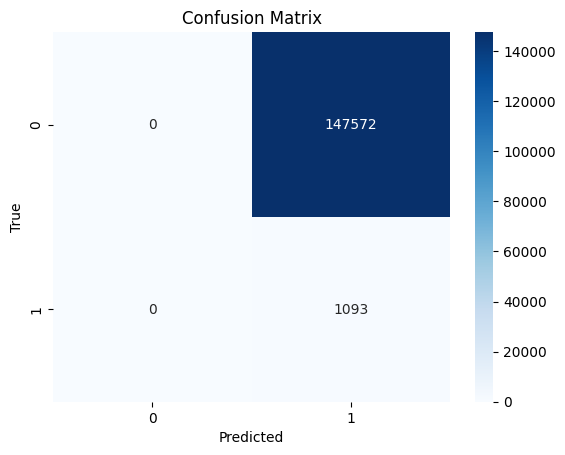

In [ ]:
# Visualizing balanced accuracy

# plt.figure(figsize=(10, 6))
# plt.bar(['Training Set', 'Validation Set'], [balanced_acc_train, balanced_acc_val])
# plt.xlabel('Data Set')
# plt.ylabel('Balanced Accuracy')
# plt.title('Balanced Accuracy for Training and Validation Sets')
# plt.show()

sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


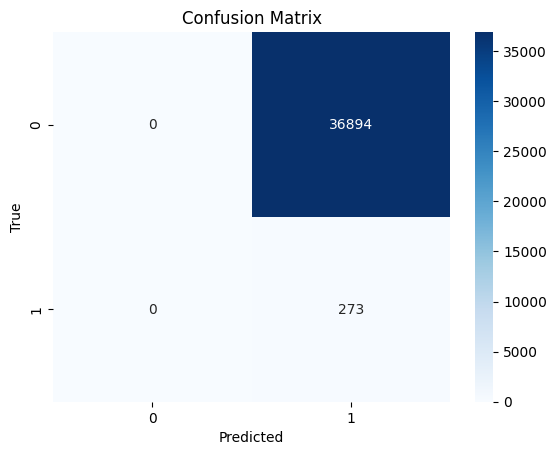

In [ ]:
sns.heatmap(confusion_matrix(y_val, y_pred_val), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
report_val = classification_report(y_train, y_pred_train, target_names=['Not Connected', 'Connected'])
print("Classification Report:")
print(report_val)

conf_matrix_val = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix:")
print(conf_matrix_val)

Classification Report:
               precision    recall  f1-score   support

Not Connected       0.99      0.99      0.99    147572
    Connected       0.01      0.01      0.01      1093

     accuracy                           0.99    148665
    macro avg       0.50      0.50      0.50    148665
 weighted avg       0.99      0.99      0.99    148665

Confusion Matrix:
[[146466   1106]
 [  1084      9]]


In [ ]:
report_val = classification_report(y_val, y_pred_val, target_names=['Not Connected', 'Connected'])
print("Classification Report:")
print(report_val)

conf_matrix_val = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix_val)

In [ ]:
lb_data["connected"][:10]

0     True
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: connected, dtype: bool

### XGBoost Model

In [ ]:
# val_data["pred"] = xgboost_classifier(train_data.loc[:, train_data.columns != "connected"], train_data["connected"], val_data.loc[:, train_data.columns != "connected"], scaler_type='MinMaxScaler')

Initializing XGBoost Classifier...
Applying Random Over Sampler...
Scaling Data...
Grid Search w/ Stratified K-Fold f/ Best Fit Model...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1.0, 'scale_pos_weight': 1}
Predicting from Grid Searched Best Fit Model...


### Linear Support Vector Machine

In [ ]:
val_data["pred"] = svm_classifier(train_data.loc[:, data.columns != "connected"], train_data["connected"], val_data.loc[:, val_data.columns != "connected"])

## Train &amp; Test Classifiers w/ Leaderboard Data

### Isolation Forest

In [ ]:
lb_data["connected"] = [True if x == -1 else False for x in isolation_forest.predict(lb_data.loc[:, lb_data.columns != "ID"])]

### XGBoost Model

In [ ]:
lb_data["pred"] = xgboost_pipeline(data.loc[:, data.columns != "connected"], data["connected"], lb_data)

lb_data["connected"] = lb_data["pred"] > .5

Initializing XGBoost Classifier...
Applying Random Over Sampler...
Scaling Data...
Grid Search w/ Stratified K-Fold f/ Best Fit Model...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_lambda': 0.01, 'scale_pos_weight': 5}
Predicting from Grid Searched Best Fit Model...


### Linear Support Vector Machine

In [ ]:
lb_data["pred"] = svm_classifier(data.loc[:, data.columns != "connected"], data["connected"], lb_data, scaler_type='StandardScaler')

# print(type(lb_data["pred"].values), lb_data["pred"].values)

lb_data["connected"] = lb_data["pred"]

## Evaluate Validation &amp; Testing Metrics

### Linear SVM Results

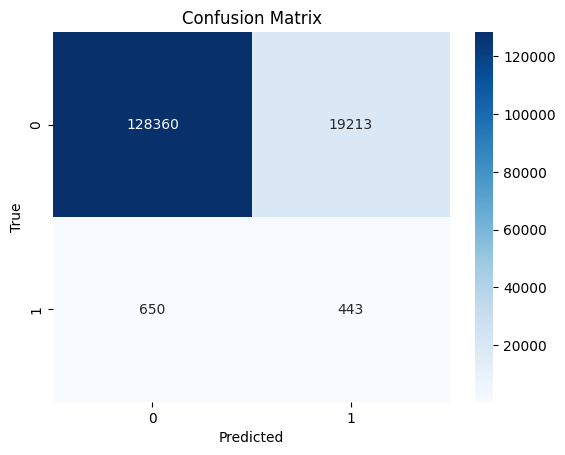

accuracy: 0.8663917775416033
XGBoost Balanced Accuracy Score: 0.6375566516806119


In [ ]:
sns.heatmap(confusion_matrix(val_data['connected'], val_data['pred'] > .5), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# print(confusion_matrix(val_data['connected'], val_data['pred'] > .5))

print(f"accuracy: {accuracy_score(val_data['connected'], val_data['pred']  > .5)}")

print(f"XGBoost Balanced Accuracy Score: {balanced_accuracy_score(val_data['connected'], val_data['pred']  > .5)}")

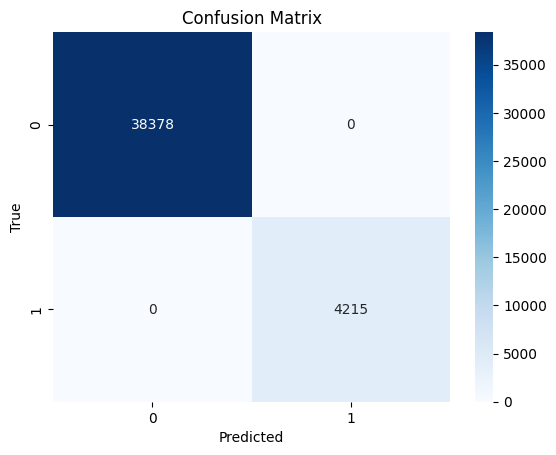

accuracy: 1.0
XGBoost Balanced Accuracy Score: 1.0


In [ ]:
sns.heatmap(confusion_matrix(lb_data['connected'], lb_data['pred'] > .5), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# print(confusion_matrix(lb_data['connected'], lb_data['pred'] > .5))

print(f"accuracy: {accuracy_score(lb_data['connected'], lb_data['pred']  > .5)}")

print(f"XGBoost Balanced Accuracy Score: {balanced_accuracy_score(lb_data['connected'], lb_data['pred']  > .5)}")

### XGBoost Results

In [ ]:
print(confusion_matrix(val_data['connected'], val_data['pred'] > .5))

print(f"accuracy: {accuracy_score(val_data['connected'], val_data['pred']  > .5)}")

print(f"XGBoost Balanced Accuracy Score: {balanced_accuracy_score(val_data['connected'], val_data['pred']  > .5)}")

[[143449   4124]
 [   953    140]]
accuracy: 0.9658496226440477
XGBoost Balanced Accuracy Score: 0.5500711701360337


In [ ]:
print(confusion_matrix(lb_data['connected'], lb_data['pred'] > .5))

print(f"accuracy: {accuracy_score(lb_data['connected'], lb_data['pred']  > .5)}")

print(f"XGBoost Balanced Accuracy Score: {balanced_accuracy_score(lb_data['connected'], lb_data['pred']  > .5)}")

[[27832     0]
 [    0 14761]]
accuracy: 1.0
XGBoost Balanced Accuracy Score: 1.0


## Save Leaderboard Predictions

In [ ]:
submission_data = lb_data.filter(['ID','connected'])

submission_data.to_csv('./drive/MyDrive/neuron-synapse-prediction/if_submission.csv',index=False)